In [11]:
from qat.lang.AQASM import Program, QRoutine, RZ, RX, CNOT, H, X, Z
from qat.core import Observable, Term
from qat.qpus import get_default_qpu, PyLinalg
from qat.plugins import ScipyMinimizePlugin
from copy import deepcopy
import matplotlib.pyplot as plt
import math as m

from pysat.formula import CNF

# Hands-on Algoritmo de Grover

## Sumário do Algoritmo de Grover

1. Começando no estado $\ket{0}^{\otimes n}$, aplique uma porta de Hadamard em cada qubit para gerar a superposição em todos os estados $$\ket{E} = \frac{\sum_x \ket{x}}{\sqrt{N}}$$

2. Repita a seguintes iterações de Grover aproximadamente $\pi \frac{\sqrt{N}}{4}$ vezes:
    - Reflita sobre o estado $\ket{s}$ usando um oráculo
    - Reflita sobre o estado $\ket{E}$ usando o difusor

3. Faça a medida para obter a solução da busca $s$ com probabilidade de pelo menos $1-\frac{1}{N}$

4. Use o oráculo uma última vez para verificar se a solução encontrada é uma resposta para o problema. Caso seja, retorne a solução. Se não, repita o algoritmo.



# Exercícios

1. Estenda o algoritmo de Grover para mais do que 1 elemento marcado. Suponha que o número de elementos marcados seja $m$. Modifique apenas o operdor $U_f$ usando uma porta Toffoli multiqubit para cada elemento marcado. Faça uma implementação que mostre que tempo de execução ideal é $\left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{m}}\right\rfloor$.

2. Implemente o algoritmo de Grover sem usar o segundo registrador. Use Capítulo 9 Seção 9.5 de https://arxiv.org/abs/2201.10574.

Observação: A solução destes exercícios será apresentada nas aulas Hands-on.

### Exercício 1

In [12]:
#targets = [(1,1,0,1,0), (0,1,0,1,0)]
targets = [(1,1,0,1,0)]
num_qubits = len(targets[0])

In [13]:
def initial_state(num_qubits):
    routine = QRoutine()
    wires = routine.new_wires(num_qubits)
    ancilla = routine.new_wires(1)
    routine.set_ancillae(ancilla)
    for q in wires:
        H(q)
    X(ancilla)
    H(ancilla)

    return routine

def clean_ancilla(num_qubits):
    routine = QRoutine()
    wires = routine.new_wires(num_qubits)
    ancilla = routine.new_wires(1)
    routine.set_ancillae(ancilla)

    H(ancilla)
    X(ancilla)

    return routine

initial = initial_state(num_qubits)
clean = clean_ancilla(num_qubits)

In [14]:
def oracle_multiple_targets(num_qubits, targets):
    routine = QRoutine()
    wires = routine.new_wires(num_qubits)
    ancilla = routine.new_wires(1)
    routine.set_ancillae(ancilla)

    for e in targets:
        for i,val in enumerate(e):
            if val == 0:
                X(wires[i])
        X.ctrl(num_qubits)(wires, ancilla)
        for i,val in enumerate(e):
            if val == 0:
                X(wires[i])
    return routine

oracle = oracle_multiple_targets(num_qubits, targets)

In [15]:
def diffusion(num_qubits):
    routine = QRoutine()
    wires = routine.new_wires(num_qubits)
    ancilla = routine.new_wires(1)
    routine.set_ancillae(ancilla)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in wires:
        H(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in wires:
        X(qubit)
    # Do multi-controlled-Z gate
    X.ctrl(len(wires))(wires, ancilla)
    # Apply transformation |11..1> -> |00..0>
    for qubit in wires:
        X(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in wires:
        H(qubit)

    return routine

diffusion_operator = diffusion(num_qubits)

Número ótimo de repetições: 4
Com 1 repetições: 
Estado |11010>|Anc:0>: probabilidade 0.25830078124999933 amplitude (-0.5082329989778304+0j) 
Probabilidade de sucesso:  0.25830078124999933
******************************************************************************
Com 2 repetições: 
Estado |11010>|Anc:0>: probabilidade 0.6024246215820284 amplitude (0.7761601777867945+0j) 
Probabilidade de sucesso:  0.6024246215820284
******************************************************************************
Com 3 repetições: 
Estado |11010>|Anc:0>: probabilidade 0.8969365358352603 amplitude (-0.947067334372409+0j) 
Probabilidade de sucesso:  0.8969365358352603
******************************************************************************
Com 4 repetições: 
Estado |11010>|Anc:0>: probabilidade 0.9991823155432856 amplitude (0.9995910741614721+0j) 
Probabilidade de sucesso:  0.9991823155432856
******************************************************************************
Com 5 repetições: 
Estado |

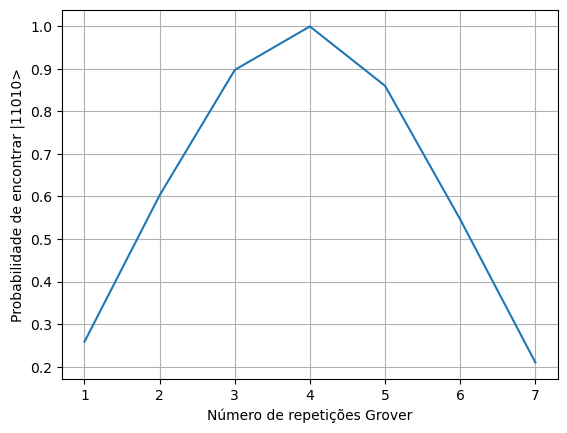

In [16]:
probs = []
repetitions = []
N = 2**num_qubits
t_opt = m.floor(m.pi/4 * m.sqrt(N/len(targets)))
print('Número ótimo de repetições:',t_opt)


# Initializing the first register as |psi_0>
for i in range(1,t_opt*2):
    qprog = Program()
    Qr = qprog.qalloc(num_qubits)

    initial(Qr)
    for j in range(i):
        oracle(Qr)
        diffusion_operator(Qr)
    clean(Qr)

    # Export this program into a quantum circuit
    circuit = qprog.to_circ()

    # import one Quantum Processor Unit Factory
    from qat.qpus import PyLinalg
    # Create a Quantum Processor Unit
    linalgqpu = PyLinalg()
    # Create a job
    job = circuit.to_job()
    # Submit the job to the QPU
    result = linalgqpu.submit(job)

    # Iterate over the final state vector to get all final components
    print('Com '+str(i)+' repetições: ')
    prob = 0
    for sample in result:
        for e in targets:
            if ('|' + ''.join(map(str,e)) in str(sample.state)):
                print("Estado %s: probabilidade %s amplitude %s " % (sample.state, sample.probability, sample.amplitude))
                prob+=sample.probability
    print('Probabilidade de sucesso: ',prob)
    probs.append(prob)
    repetitions.append(i)
    print('******************************************************************************')

plt.plot(repetitions, probs)
plt.xlabel('Número de repetições Grover')
plt.ylabel('Probabilidade de encontrar '+'|' + ''.join(map(str,targets[0]))+'>')
plt.grid(True)
plt.show()

### Exercício 2

In [17]:
def economic_initial(num_qubits):
    routine = QRoutine()
    wires = routine.new_wires(num_qubits)
    for q in wires:
        H(q)

    return routine

qprog = Program()
e_initial = economic_initial(num_qubits)
qbits = qprog.qalloc(num_qubits)
e_initial(qbits)
circuit = qprog.to_circ()
print("total number of gates: ", len(circuit.ops))
# Display quantum circuit
%qatdisplay circuit --svg

total number of gates:  5


In [18]:
def economic_diffusion(num_qubits):
    routine = QRoutine()
    wires = routine.new_wires(num_qubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in wires[:-1]:
        H(qubit)
        X(qubit)
    # Do multi-controlled-Z gate
    Z(wires[-1])
    X.ctrl(len(wires)-1)(wires[:-1], wires[-1])
    Z(wires[-1])
    # Apply transformation |11..1> -> |00..0>
    for qubit in wires[:-1]:
        X(qubit)
        H(qubit)
    # Apply transformation |00..0> -> |s>

    return routine

qprog = Program()
e_diff = economic_diffusion(num_qubits)
qbits = qprog.qalloc(num_qubits)
e_diff(qbits)
circuit = qprog.to_circ()
print("total number of gates: ", len(circuit.ops))
# Display quantum circuit
%qatdisplay circuit --svg

total number of gates:  11


In [19]:
def economic_oracle(num_qubits, targets):
    routine = QRoutine()
    wires = routine.new_wires(num_qubits)

    for e in targets:
        for i,val in enumerate(e):
            if val == 0:
                X(wires[i])
            if i == len(e)-1:
                H(wires[i])
            else:
                X(wires[i])
        X.ctrl(num_qubits-1)(wires[:-1], wires[-1])
        for i,val in enumerate(e):
            if i == len(e)-1:
                H(wires[i])
            else:
                X(wires[i])
            if val == 0:
                X(wires[i])

    return routine

qprog = Program()
e_oracle = economic_oracle(num_qubits, targets)
qbits = qprog.qalloc(num_qubits)
e_oracle(qbits)
circuit = qprog.to_circ()
print("total number of gates: ", len(circuit.ops))
# Display quantum circuit
%qatdisplay circuit --svg

total number of gates:  15


Número ótimo de repetições: 4
Com 1 repetições: 
Estado |11010>: probabilidade 0.031249999999999955 amplitude (0.17677669529663675+0j) 
Probabilidade de sucesso:  0.031249999999999955
******************************************************************************
Com 2 repetições: 
Estado |11010>: probabilidade 0.031249999999999934 amplitude (0.1767766952966367+0j) 
Probabilidade de sucesso:  0.031249999999999934
******************************************************************************
Com 3 repetições: 
Estado |11010>: probabilidade 0.031249999999999917 amplitude (0.17677669529663664+0j) 
Probabilidade de sucesso:  0.031249999999999917
******************************************************************************
Com 4 repetições: 
Estado |11010>: probabilidade 0.031249999999999896 amplitude (0.1767766952966366+0j) 
Probabilidade de sucesso:  0.031249999999999896
******************************************************************************
Com 5 repetições: 
Estado |11010>: proba

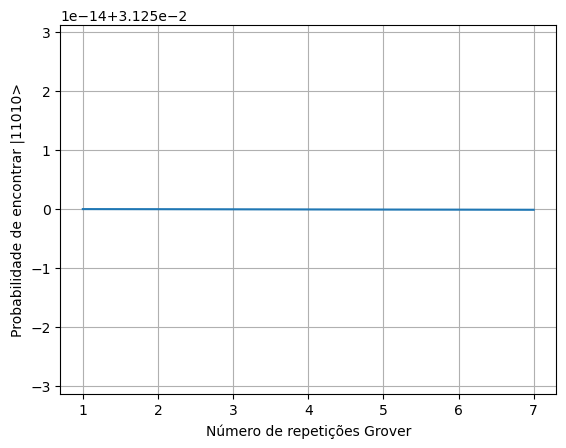

In [20]:
probs2 = []
repetitions2 = []
N = 2**num_qubits
t_opt = m.floor(m.pi/4 * m.sqrt(N/len(targets)))
print('Número ótimo de repetições:',t_opt)


# Initializing the first register as |psi_0>
for i in range(1,t_opt*2):
    qprog2 = Program()
    Qr2 = qprog2.qalloc(num_qubits)

    e_initial(Qr2)
    for j in range(i):
        e_oracle(Qr2)
        e_diff(Qr2)

    # Export this program into a quantum circuit
    circuit2 = qprog2.to_circ()

    # Create a Quantum Processor Unit
    linalgqpu = PyLinalg()
    # Create a job
    job2 = circuit2.to_job()
    # Submit the job to the QPU
    result = linalgqpu.submit(job2)

    # Iterate over the final state vector to get all final components
    print('Com '+str(i)+' repetições: ')
    prob = 0
    for sample in result:
        for e in targets:
            if ('|' + ''.join(map(str,e)) in str(sample.state)):
                print("Estado %s: probabilidade %s amplitude %s " % (sample.state, sample.probability, sample.amplitude))
                prob+=sample.probability
    print('Probabilidade de sucesso: ',prob)
    probs2.append(prob)
    repetitions2.append(i)
    print('******************************************************************************')

plt.plot(repetitions2, probs2)
plt.xlabel('Número de repetições Grover')
plt.ylabel('Probabilidade de encontrar '+'|' + ''.join(map(str,targets[0]))+'>')
plt.grid(True)
plt.show()